In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

import czifile
from pathlib import Path
import os
from skimage import morphology, exposure, filters
from skimage.feature import canny
from skimage.measure import regionprops, label
from scipy import ndimage, misc

In [2]:
channel_dict = {'DAPI': 0, 'gt':2, 'pho':3, 'hb':4}
z_plane = 27 # midsaggital slice variable
bkgd_signal = 150
file_name = 'wt_20210510_gthb_5.czi'
work_dir = '/Users/robinhood/Dropbox (HMS)/Data/imaging/processing'
channel_list = ['DAPI', 'gt', 'pho', 'hb'] #keep for iteration
max_channel = 'DAPI'
ap_channel = 'DAPI'
dv_channel = 'hb'
kd_channel = 'pho'
out_channels = ['gt', 'hb']
xdim = 1024
ydim = 1024

In [3]:
os.chdir(work_dir)

cur_dir = Path.cwd()
print(f"The current directory is {cur_dir}\n")

# specify a relative or absolute directory
#data_dir = Path("data")

czi = czifile.imread(file_name)
img=czi.squeeze()

data = {}
for channel in channel_list:
    data[channel] = img[channel_dict[channel],...]


The current directory is /Users/robinhood/Dropbox (HMS)/Data/imaging/processing



In [5]:
# max_projection_DAPI = img_DAPI.max(0)
max_projection = data[ap_channel].max(0) # this will be how to pick AP axis
saggital_max = data[max_channel][z_plane,:,:]
saggital_dv = data[dv_channel][z_plane,:,:]

In [6]:
normalized = exposure.adjust_gamma(saggital_max)
hyst_max = filters.apply_hysteresis_threshold(normalized, bkgd_signal, np.max(normalized)-1)
closed = morphology.binary_closing(hyst_max)
edges = canny(closed, sigma=2.0, low_threshold=0.55, high_threshold=0.8) 

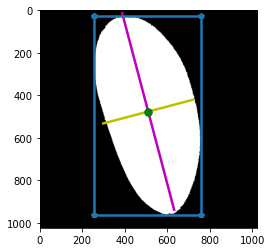

In [7]:
emb_label= label(closed.astype(np.uint8))
emb_regions = regionprops(closed.astype(np.uint8))

fig, ax = plt.subplots()
ax.imshow(closed, cmap=plt.cm.gray)

for props in emb_regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    minr, minc, maxr, maxc = props.bbox

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length #top
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length #bottom
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
    
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length


ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-p', linewidth=2.5)

plt.show()

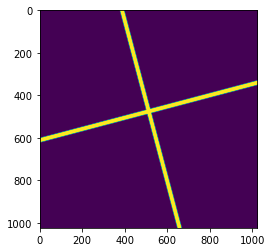

In [8]:
## making the knives

minor_axis_line = np.zeros((ydim, xdim), dtype=bool)
major_axis_line = np.zeros((ydim, xdim), dtype=bool)

m_minor = (y1 - y0) / (x1 - x0)
b_minor = (y1 - (m_minor * x1))
m_major = (y2 - y0) / (x2 - x0)
b_major = (y2 - (m_major * x2))

# minor axis loop
minor_inds = []
for x in range(minor_axis_line.shape[1]):
    y = ((m_minor * x) + b_minor)
    if y < minor_axis_line.shape[1] and y >= 0:
        minor_axis_line[int(y),int(x)] = True
        minor_inds.append((int(y), (int(x))))

# major axis loop
major_inds = [] # list
for x in range(major_axis_line.shape[0]):
    y = ((m_major * x) + b_major)
    if y < major_axis_line.shape[0] and y >= 0:
        major_axis_line[int(y),int(x)] = True
        major_inds.append([int(y), int(x)])


footprint=morphology.disk(10)

major_axis_knife = morphology.binary_dilation(major_axis_line, footprint)
minor_axis_knife = morphology.binary_dilation(minor_axis_line, footprint)

fig, ax = plt.subplots()
ax.imshow(minor_axis_knife + major_axis_knife)

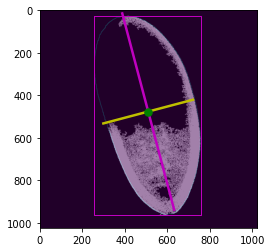

In [9]:
normalized_dv = exposure.adjust_gamma(saggital_dv)
hyst_dv = filters.apply_hysteresis_threshold(normalized_dv, bkgd_signal, np.max(normalized)-1)

fig, ax = plt.subplots()
ax.imshow(hyst_dv, cmap=plt.cm.gray)

ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-m', linewidth=1)

#np.max(hysterics_snail)
ax.imshow(edges, alpha=0.5) #rgba look into for transparency


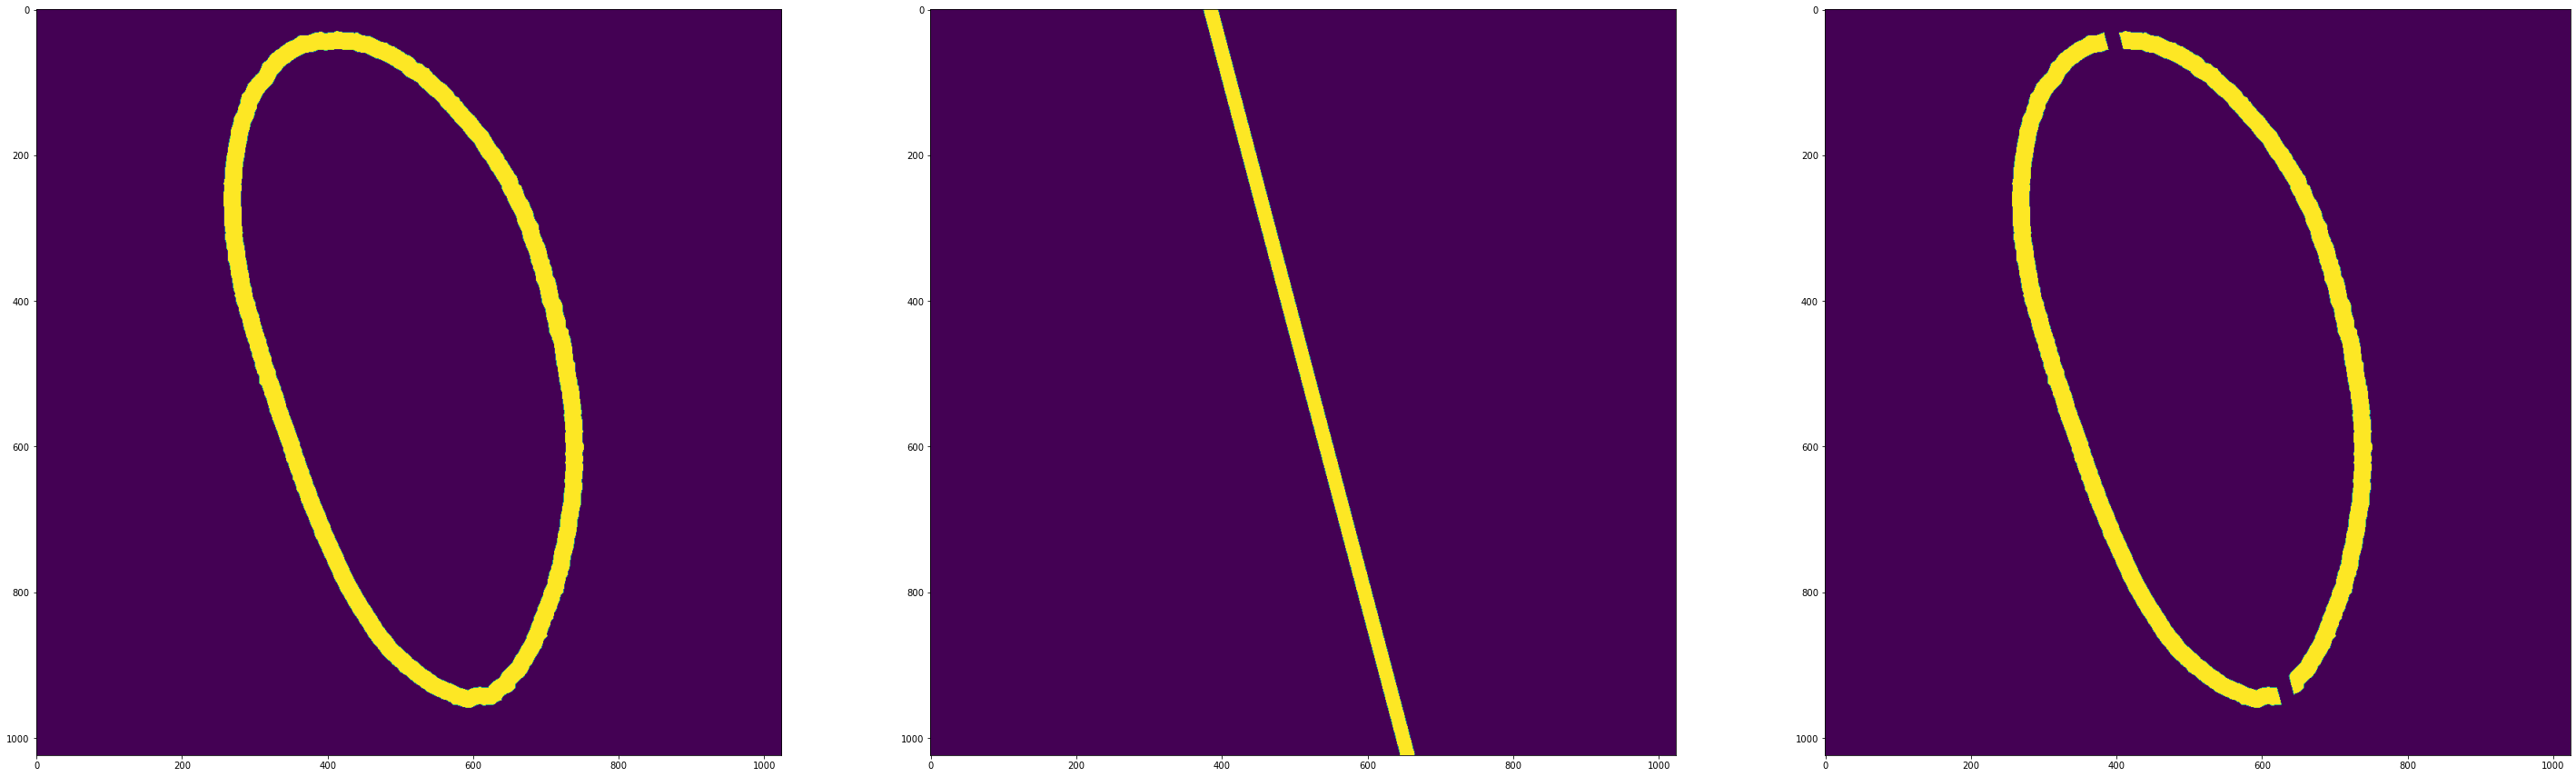

In [10]:
#dilates the edges for analysis
footprint=morphology.disk(25)
dil1 = morphology.binary_dilation(edges, footprint)

# makes a better oval from edges
dilated_edge = morphology.binary_dilation(edges) # fills a hole in edges
better_closed = morphology.flood(dilated_edge, (int(y0), int(x0)))

zorro = better_closed*dil1 # slices off all the extra in dil 1 to make a mask of the area of interest in the embryo
dv_divide = np.invert(major_axis_knife) * zorro # cuts the zorro mask with the knife

fig, ax = plt.subplots(1,3, figsize=(50,150))
ax[0].imshow(zorro)
ax[1].imshow(major_axis_knife)
ax[2].imshow(dv_divide)

In [11]:
# makes sure that the cut is big enough for regionprops to see
dv_label = label(dv_divide)
dv_regions = regionprops(dv_label)

# dv_props = regionprops_table(dv_label, properties=('area', 'perimeter', 'bbox'))
# pd.DataFrame(dv_props)

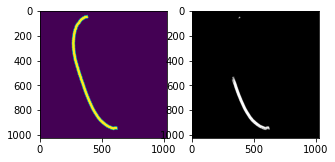

In [13]:
#seperate the two sides of the embryo

blank = np.zeros((ydim, xdim), dtype=bool)

sideA = blank.copy()
bbox = dv_regions[0].bbox
sideA[bbox[0]:bbox[2], bbox[1]:bbox[3]] = dv_regions[0].image

sideB = blank.copy()
bbox = dv_regions[1].bbox
sideB[bbox[0]:bbox[2], bbox[1]:bbox[3]] = dv_regions[1].image

# use the two sides and mask the snail hysterics image

decide_A = hyst_dv*sideA
decide_B = hyst_dv*sideB

# decision point for the DV axis

if np.sum(decide_A) > np.sum(decide_B):
    dorsal = sideB
    dorsal_check = decide_B
else:
         dorsal = sideA
         dorsal_check = decide_A


fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(dorsal)
ax[1].imshow(dorsal_check, cmap=plt.cm.gray)

# MAKE AN OUTPUT FILE FOR FILENAME SO CAN GO BACK AND CHECK THIS 

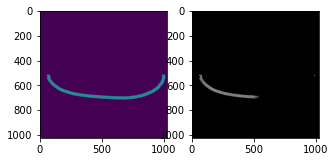

In [19]:
# do this rotation on whole data [] 
rotation_axis = 90 - (orientation * 180/math.pi)
rotate_dorsal_mask = ndimage.rotate(dorsal, rotation_axis, reshape=False)
rotate_dorsal_check = ndimage.rotate(dorsal_check, rotation_axis, reshape=False)
 # WRITE IN A/P IF/ELSE FOR PROPER BEAN FLICKING
flip = True
if flip:
    rotate_dorsal_mask = np.fliplr(rotate_dorsal_mask) 
    rotate_dorsal_check = np.fliplr(rotate_dorsal_check) 



fig, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(rotate_dorsal_mask)
ax[1].imshow(rotate_dorsal_check, cmap=plt.cm.gray)

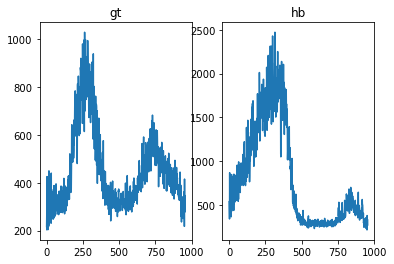

In [18]:
out_traces = {}
for out in out_channels:
    dorsal_signal = dorsal * data[out][z_plane,:,:]
    rotate_out = ndimage.rotate(dorsal_signal, rotation_axis, reshape=False)
    if flip:
        rotate_out = np.fliplr(rotate_out)
    sum_trace = rotate_out.sum(axis=0)
    mask_sum = rotate_dorsal_mask.sum(axis=0)
    out_traces[out] = sum_trace[mask_sum>0] / mask_sum[mask_sum>0]

fig, ax = plt.subplots(1,len(out_channels))
for i, out in enumerate(out_channels):
    ax[i].plot(out_traces[out], label=out)
    ax[i].set_title(out)


In [13]:
# do this rotation on whole data [] 
rotation_axis = 90 - (orientation * 180/math.pi)
rotate_dorsal_mask = ndimage.rotate(dorsal, rotation_axis, reshape=False)